<a href="https://colab.research.google.com/github/StephanieJax/readme-edits/blob/readme-edits/ScaniaTruckAPSFailures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by: Stephanie Jax
CS4347 Spring 2021 



In [ ]:
# Get data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/ScaniaTrucks/* ./

Mounted at /content/drive


In [ ]:
#Check data
!ls

aps_failure_description.txt  aps_failure_training_set.csv  sample_data
aps_failure_test_set.csv     drive


In [ ]:
# Imports
import pandas as pd
import numpy as np
import graphviz
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Organizing/Cleaning Training Data
aps_failure_training_set = "aps_failure_training_set.csv"
train_df = pd.read_csv(aps_failure_training_set)

# Print the head/tail of the data to make sure it was imported properly
print("Original data before any changes were made:\n")
print(train_df.head())
print(train_df.tail())
print("--------------------------------------------\n")

# Replace 'na' values, which Pandas did not recognize as true NA values, with numpy "NaN" values
# This allows the .isna method to work properly and, as a result, the .dropna method to work as well.
train_df.replace('na', np.nan, inplace=True)

# Replace "neg" and "pos" with corresponding boolean values
train_df.replace('neg', 0, inplace=True)
train_df.replace('pos', 1, inplace=True)

# Print the head/tail of the data to confirm the changes
print("Data after converting class strings to numerical boolean values:\n")
print(train_df.head())
print(train_df.tail())
print("--------------------------------------------\n")


Original data before any changes were made:

  class  aa_000 ab_000      ac_000 ad_000  ...  ee_007  ee_008 ee_009 ef_000 eg_000
0   neg   76698     na  2130706438    280  ...  157956   73224      0      0      0
1   neg   33058     na           0     na  ...   81140   97576   1500      0      0
2   neg   41040     na         228    100  ...  158022   95128    514      0      0
3   neg      12      0          70     66  ...       0       0      0      4     32
4   neg   60874     na        1368    458  ...  311560  433954   1218      0      0

[5 rows x 171 columns]
      class  aa_000 ab_000      ac_000  ...  ee_008  ee_009 ef_000 eg_000
59995   neg  153002     na         664  ...  898642   28588      0      0
59996   neg    2286     na  2130706538  ...       0       0      0      0
59997   neg     112      0  2130706432  ...       0       0      0      0
59998   neg   80292     na  2130706432  ...  802280  388422      0      0
59999   neg   40222     na         698  ...  170384     1

In [ ]:
# Organizing/Cleaning Test Data
aps_failure_test_set = "aps_failure_test_set.csv"
test_df = pd.read_csv(aps_failure_test_set)

# Print the head/tail of the data to make sure it was imported properly
print("Original data before any changes were made:\n")
print(test_df.head())
print(test_df.tail())
print("--------------------------------------------\n")

# Replace 'na' values, which Pandas did not recognize as true NA values, with numpy "NaN" values
# This allows the .isna method to work properly and, as a result, the .dropna method to work as well.
test_df.replace('na', np.nan, inplace=True)

# Replace "neg" and "pos" with corresponding boolean values
test_df.replace('neg', 0, inplace=True)
test_df.replace('pos', 1, inplace=True)

# Print the head/tail of the data to confirm the changes
print("Data after converting class strings to numerical boolean values:\n")
print(test_df.head())
print(test_df.tail())
print("--------------------------------------------\n")

Original data before any changes were made:

  class  aa_000 ab_000 ac_000 ad_000  ...  ee_007  ee_008 ee_009 ef_000 eg_000
0   neg      60      0     20     12  ...      88       0      0      0      0
1   neg      82      0     68     40  ...     462       0      0      0      0
2   neg   66002      2    212    112  ...  153680     516      0      0      0
3   neg   59816     na   1010    936  ...  210074  281662   3232      0      0
4   neg    1814     na    156    140  ...     482      76      0      0      0

[5 rows x 171 columns]
      class  aa_000 ab_000      ac_000  ...  ee_008 ee_009 ef_000 eg_000
15995   neg   81852     na  2130706432  ...  960024  25566      0      0
15996   neg      18      0          52  ...       0      0      0      0
15997   neg   79636     na        1670  ...  358934  19548      0      0
15998   neg     110     na          36  ...      74      0      0      0
15999   neg       8      0           6  ...       0      0      0      0

[5 rows x 171 colu

In [ ]:
# Building the models
y_train = train_df["class"]
X_train = train_df.drop("class", axis = 1)
y_test = test_df["class"]
X_test = test_df.drop("class", axis = 1)

In [ ]:
# Building a training function for Random Forest Classification
# Instead of dropping "NaN" values, we replace them with the imputed means of surrounding, similar values
# If we were to simply drop the NaN values, we'd exclude roughly 99% of our datasets (~170 samples versus ~16000 for the test set)
# We chose 42 as the random state since 42 is the answer to life, the universe, and everything
# Pipeline is used to apply a variety of transforms such as filling NaN values with imputed means, SMOTE for balancing, 
# and RandomForestClassifier for classification
# Final output is given by CalibratedClassifierCV function which utilizes the most ideal estimators

def train(X: pd.DataFrame, y: pd.DataFrame):
    impute_mean = SimpleImputer(missing_values = np.NaN, 
                            strategy = "mean")

    smote = SMOTE(random_state = 42)

    tuned_parameters = {"Classifier__max_depth": [2, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50],
                        "Classifier__n_estimators": [10, 20, 30, 35, 40, 50, 80, 100, 150, 200],
                        "Classifier__max_features": ['auto', 'sqrt', 'log2'],
                        "Classifier__class_weight": ['balanced', 'balanced_subsample', None]
                        }
    clf = RandomForestClassifier(n_jobs=-1, random_state = 42)

    pipeline = Pipeline([("impute", impute_mean),
                         ("SMOTE", smote),
                         ("Classifier", clf)])

    model = RandomizedSearchCV(pipeline, tuned_parameters, cv=5, scoring="recall", n_jobs=-1, n_iter=1)
    model.fit(X, y)

    calib = CalibratedClassifierCV(model.best_estimator_, cv=5, method = "sigmoid")
    calib.fit(X, y)
                          
    return calib
 
classifier = train(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

0.7639484978540771


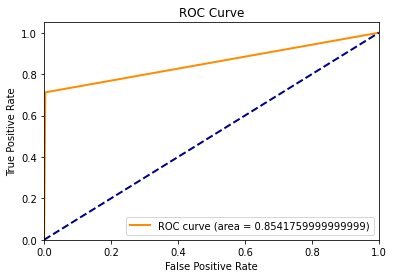

In [ ]:
# Computing evaluation metrics
y_pred = classifier.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f1)
    
# ROC curve and metrics
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2 
plt.plot(fpr, tpr, color = "darkorange", lw=lw, label=f"ROC curve (area = {roc_auc})")
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

Confusion matrix:
[[15568    57]
 [  108   267]]


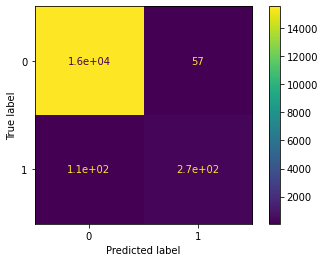

0.7639484978540771


In [ ]:
# Evaluating the confusion matrix
from sklearn.metrics import plot_confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))
plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()  
print(f1)

In [ ]:
# Simple KNN calculation
# Accuracy is skewed since the dataset is drastically smaller with dropped NaN values instead of imputed NaN values
# We did this for the sake of efficiency. I gave up on letting the code run its course after ~3 hours of runtime.
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

y_train = train_df["class"]
X_train = train_df.drop("class", axis = 1)
y_test = test_df["class"]
X_test = test_df.drop("class", axis = 1)

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.8363636363636363
